In [436]:
import json
import pprint
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
import collections
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import itertools
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.model_selection import GridSearchCV
import datetime, time
import pytz
import statsmodels.api as stats_api
import os
import csv

In [2]:
pp = pprint.PrettyPrinter(indent=2)
with open('tweet_data/tweets_#gohawks.txt') as json_data:
    for line in json_data:
        d = json.loads(line)
        pp.pprint(d)
        break

{ 'author': { 'author_img': 'http://pbs.twimg.com/profile_images/561716455155064833/XGrpP4Rl_normal.jpeg',
              'description': 'Married to my best friend... You-make me laugh '
                             'and occasionally think... I-will let you in on '
                             'some of the crazy shit that consumes my '
                             'thoughts...',
              'followers': 1752.0,
              'image_url': 'http://pbs.twimg.com/profile_images/561716455155064833/XGrpP4Rl_normal.jpeg',
              'name': 'RJ',
              'nick': 'rejinseattle',
              'type': 'twitter',
              'url': 'http://twitter.com/rejinseattle'},
  'citation_date': 1421518778,
  'citation_url': 'http://twitter.com/REJinseattle/status/556516209261166593',
  'firstpost_date': 1419804875,
  'highlight': 'I &lt;3 our defense! #GoHawks http://t.co/U1pcXpEsR8',
  'metrics': { 'acceleration': 0,
               'citations': { 'data': [ { 'citations': 1,
                 

# 1. Popularity Prediction

#### Initialize variables

In [410]:
hashtags = ['#gopatriots','#nfl','#sb49','#gohawks','#patriots','#superbowl'] #using only one tag
#hashtags = ['#sb49','#gohawks','#patriots','#superbowl'] #using only one tag

#### Reading files into dataframes and storing

In [313]:
df_columns = ['timestamp','tweet_id','author_id','followers','retweets',
              'firstpost',
              'acceleration','impressions','peak', 'ranking_score', 
              'org_followers', 
              'title', 
              'user_mentions', 
              'favorite_count', 'sensitivity', 'retweet_count', 'location']
bypass = False
for hashtag in hashtags:
    df = pd.DataFrame(columns=df_columns)
    lno = 0
    print("Processing ",hashtag)
    with open("tweet_data/tweets_"+hashtag+".txt", "r") as file_obj:
        if(not os.path.isfile('temp/'+hashtag+'.csv') or bypass):
            writer=csv.writer(open('temp/'+hashtag+'.csv','w'))
            writer.writerow(df_columns)
            line = file_obj.readline()
            while(line):
                if(lno%20000 == 0):
                    print(lno)
                j = json.loads(line)
                lno+=1
                #pp.pprint(j)
                #must need columns
                timestamp =j['citation_date']
                followers =j['author']['followers']
                retweets = j['metrics']['citations']['total']
                #useful for later
                author_id = j['author']['url']
                tweet_id = j['tweet']['id']
                # additional features
                firstpost = j['firstpost_date']
                acceleration = j['metrics']['acceleration']
                impressions = j['metrics']['impressions']
                peak = j['metrics']['peak']
                ranking_score = j['metrics']['ranking_score']
                org_followers = j['original_author']['followers']
                #influence = j['original_author']['influence_level']
                title = j['title']
                user_mentions = j['tweet']['entities']['user_mentions']
                favorite_count = j['tweet']['favorite_count']
                sensitivity = j['tweet']['possibly_sensitive']
                retweet_count = j['tweet']['retweet_count']
                location=j['tweet']['user']['location']
                writer.writerow([timestamp, tweet_id, author_id, followers, retweets,
                           firstpost,
                           acceleration, impressions, peak, ranking_score, 
                           org_followers, 
                           title, 
                           user_mentions, 
                           favorite_count, sensitivity, retweet_count, location])
                line = file_obj.readline()
        else:
            print("File Exists!")

Processing  #gopatriots
File Exists!


In [516]:
df_map = {} # to store dfs for each file
for hashtag in hashtags:
    print('loaded dataframe',hashtag)
    df_map[hashtag] = pd.read_csv('temp/'+hashtag+'.csv')

loaded dataframe #gopatriots
loaded dataframe #nfl
loaded dataframe #sb49
loaded dataframe #gohawks
loaded dataframe #patriots
loaded dataframe #superbowl


In [51]:
df_map['#gopatriots'].head()

,timestamp,tweet_id,author_id,followers,retweets,firstpost,acceleration,impressions,peak,ranking_score,org_followers,title,user_mentions,favorite_count,sensitivity,retweet_count,location
0,1421257541,553650101105606656,http://twitter.com/patsnation87,2895.0,6,1420835445,0,2695,1421257559,4.640276,3811.0,LeGarrette Blount does the Ray Lewis Dance #Th...,[],0,False,0,"Boston, Massachusetts"
1,1421275471,553994483457875968,http://twitter.com/thetrumd,158.0,4,1420917552,0,146,1421275499,3.892707,1163.0,Y así será mi futuro hijo 😍🙌❤🏈💙 #GoPatriots #M...,"[{'indices': [57, 66], 'id_str': '31126587', '...",0,False,0,NaN
2,1421295565,554068000366526464,http://twitter.com/rhry8643828,52.0,33,1420935080,0,30,1421295599,4.096886,15564.0,I don't care what anyone says! Tom Brady is th...,[],0,False,1,NaN
3,1421341875,554076243038326785,http://twitter.com/ricciardelli,20896.0,3,1420937045,0,22258,1421341919,3.737522,2124.0,With both my father and husband yelling at the...,[],0,False,1,new york city.
4,1421285189,554774415914061825,http://twitter.com/soccer44life10,500.0,3,1421103502,0,482,1421285219,3.952203,1216.0,The girls soccer team is ranked the No. 3 team...,[],1,False,1,"Plantation, FL"


In [ ]:
#df_map['#gopatriots'].to_csv('#gopatriots.csv', encoding='utf-8', index=False)

## 1.1 Statistics

In [19]:
tweets_hrly = {}
retweets_hrly = {}
followers_hrly = {}
tweets_cnt = {}
retweets_cnt = {}
followers_cnt = {}

for hashtag in hashtags:
    df = df_map[hashtag]
    sec = df['timestamp'].max() - df['timestamp'].min()   
    tweets_cnt[hashtag] = df['tweet_id'].count()
    retweets_cnt[hashtag] = df['retweets'].sum()
    followers_cnt[hashtag] = df['followers'].sum()
    tweets_hrly[hashtag] = (tweets_cnt[hashtag]*3600)/sec
    retweets_hrly[hashtag] = (retweets_cnt[hashtag]*3600)/sec
    followers_hrly[hashtag] = (followers_cnt[hashtag]*3600)/sec    


In [20]:
print('Tweets Count : ',tweets_cnt)
print('Tweets Avg. hourly',tweets_hrly)
print('Retweets Count : ',retweets_cnt)
print('Retweets Avg. hourly',retweets_hrly)

print('Followers Count : ',followers_cnt)
print('Followers Avg. hourly',followers_cnt)

Tweets Count :  {'#gopatriots': 26232, '#nfl': 259024, '#sb49': 826951, '#gohawks': 188136, '#patriots': 489713, '#superbowl': 1346216}
Tweets Avg. hourly {'#gopatriots': 45.694510573562027, '#nfl': 441.3234311373958, '#sb49': 1419.8879074871904, '#gohawks': 325.3715913043311, '#patriots': 834.55550916418849, '#superbowl': 2379.7114714172076}
Retweets Count :  {'#gopatriots': 36727, '#nfl': 398517, '#sb49': 2076597, '#gohawks': 379022, '#patriots': 873068, '#superbowl': 3216922}
Retweets Avg. hourly {'#gopatriots': 63.976147065996216, '#nfl': 678.99071053872058, '#sb49': 3565.5497956035811, '#gohawks': 655.49916698213099, '#patriots': 1487.8586218355645, '#superbowl': 5686.5660384770244}
Followers Count :  {'#gopatriots': 36774523.0, '#nfl': 1205304020.0, '#sb49': 8490567936.0, '#gohawks': 414638907.0, '#patriots': 1620939662.0, '#superbowl': 11915823506.0}
Followers Avg. hourly {'#gopatriots': 36774523.0, '#nfl': 1205304020.0, '#sb49': 8490567936.0, '#gohawks': 414638907.0, '#patriots

## 1.2 Linear Regression

#### K-fold cross validation from our previous project

In [396]:
def perform_10fold(X,y,regressor, print_ = False,shuffle_= True):
    kf = KFold(n_splits=10,shuffle=shuffle_, random_state=0)
    i = 1
    bestModel = None
    tr_e = 0
    ts_e = 0
    min_ts_e = 10
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        regressor.fit(X_train,y_train)
        train_preds = regressor.predict(X_train)
        test_preds = regressor.predict(X_test)
        test_error = mean_squared_error(y_test,test_preds)
        tr_e += mean_squared_error(y_train,train_preds)
        ts_e += test_error
        if(print_):
            print("Fold : ",i)
            print("Training RMSE : ",np.sqrt(mean_squared_error(y_train,train_preds)))
            print("Test RMSE : ",np.sqrt(test_error))
        if(test_error<min_ts_e):
            min_ts_e = test_error
            bestModel = regressor
        i = i+1
    return np.sqrt(tr_e/10),np.sqrt(ts_e/10), bestModel

#### Returns the hour number from timestamp

In [42]:
pst_tz = pytz.timezone('US/Mountain')
def getHourofDay(timestamp):
    #print(timestamp)
    return datetime.datetime.fromtimestamp(timestamp, pst_tz).hour

    
def getHour(timestamp):
    return int(timestamp/3600)

def getDate(timestamp):
    return datetime.datetime.fromtimestamp(timestamp)

In [23]:
X_map = {}
Y_map = {}
for hashtag in hashtags:
    df = df_map[hashtag].copy()
    df['timestamp'] = df['timestamp'].apply(lambda x:getHour(x) )
    grouped = df.groupby('timestamp').agg({'followers': ['sum', 'max'],'tweet_id':'count', 'retweets':'sum'})
    grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
    #grouped.columns=grouped.columns.droplevel()
    grouped.reset_index(inplace=True)
    grouped['hour_of_day','tweet'] = grouped.apply(lambda x: getHourofDay(x['timestamp']*3600), axis=1)
    X_map[hashtag] = grouped.drop(['timestamp','tweet_id_count'],axis=1)
    Y_map[hashtag] = grouped['tweet_id_count']
    #print(grouped)
    

In [24]:
for hashtag in hashtags:
    model = stats_api.OLS(Y_map['#gopatriots'],X_map['#gopatriots']).fit()
    print(model.summary())
    

                            OLS Regression Results                            
Dep. Variable:         tweet_id_count   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.129e+04
Date:                Wed, 07 Mar 2018   Prob (F-statistic):               0.00
Time:                        21:51:25   Log-Likelihood:                -2216.2
No. Observations:                 447   AIC:                             4440.
Df Residuals:                     443   BIC:                             4457.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
followers_sum           

In [25]:
X_map['#gopatriots'].head()

,followers_sum,followers_max,retweets_sum,"(hour_of_day, tweet)"
0,10955.0,10955.0,4,2
1,1762.0,1762.0,3,3
2,1168.0,600.0,3,5
3,465.0,431.0,3,6
4,2850.0,1425.0,3,7


In [391]:
df_map['#gopatriots'].head()

,timestamp,tweet_id,author_id,followers,retweets,firstpost,acceleration,impressions,peak,ranking_score,org_followers,title,user_mentions,favorite_count,sensitivity,retweet_count,location
0,1421257541,553650101105606656,http://twitter.com/patsnation87,2895.0,6,1420835445,0,2695,1421257559,4.640276,3811.0,LeGarrette Blount does the Ray Lewis Dance #Th...,[],0,False,0,"Boston, Massachusetts"
1,1421275471,553994483457875968,http://twitter.com/thetrumd,158.0,4,1420917552,0,146,1421275499,3.892707,1163.0,Y así será mi futuro hijo 😍🙌❤🏈💙 #GoPatriots #M...,"[{'indices': [57, 66], 'id_str': '31126587', '...",0,False,0,NaN
2,1421295565,554068000366526464,http://twitter.com/rhry8643828,52.0,33,1420935080,0,30,1421295599,4.096886,15564.0,I don't care what anyone says! Tom Brady is th...,[],0,False,1,NaN
3,1421341875,554076243038326785,http://twitter.com/ricciardelli,20896.0,3,1420937045,0,22258,1421341919,3.737522,2124.0,With both my father and husband yelling at the...,[],0,False,1,new york city.
4,1421285189,554774415914061825,http://twitter.com/soccer44life10,500.0,3,1421103502,0,482,1421285219,3.952203,1216.0,The girls soccer team is ranked the No. 3 team...,[],1,False,1,"Plantation, FL"


<h2>Section 1.3 - Linear model</h2>

In [279]:
feature_names = ['# Tweets', '# Authors', 'Average # Followers', 'Retweets', 'Title length', 'Firstpost',
                 'Acceleration', 'Peak', 'User mentions', 'Impressions', 'Average retweet count', 
                 'Average ranking score', 'Original followers', 'Favorite count', 'Time - Hour']

In [280]:
def plot_func(X, Y, result):
    best_features = result.pvalues.argsort()[:3]
    print("Best feature plots")
    i = 1
    for index in best_features:
        print(feature_names[index])
        plt.title("Best feature "+str(i)+": "+str(feature_names[index]))
        plt.xlabel("Number of tweets for next hour")
        plt.ylabel(feature_names[index])
        plt.scatter(Y, X[:, index])
        plt.show()
        i+=1

In [531]:
def getXY(df, time_type=False):
    if time_type:
        df['timestamp'] = df['timestamp'].apply(lambda x:getDate(x))
    
    time_series = df.groupby(pd.Grouper(key='timestamp', freq='3600s'))
    time_groups = time_series.groups
    #print(time_groups)
    X = np.zeros((len(time_groups), n_features))
    Y = np.zeros((len(time_groups)))
    for i, (interval, group) in enumerate(time_series):
        num_tweets = group.tweet_id.nunique()+1 
        num_authors = group.author_id.nunique()+1
        X[i, 0] = group.tweet_id.nunique()
        X[i, 1] = group.author_id.nunique()
        X[i, 2] = group.followers.sum()/num_authors
        X[i, 3] = group.retweets.sum()
        X[i, 4] = group.title.apply(lambda x:len(x)).max()
        X[i, 5] = group.firstpost.min()
        X[i, 6] = group.acceleration.sum()
        X[i, 7] = group.peak.max()
        X[i, 8] = len(group.user_mentions)
        X[i, 9] = group.impressions.sum()
        X[i,10] = group.retweet_count.sum()/num_tweets
        X[i,11] = group.ranking_score.sum()/num_tweets
        X[i,12] = group.org_followers.sum()
        X[i,13] = group.favorite_count.sum()
        X[i,14] = interval.hour
        
        Y[i] = group.tweet_id.nunique()
    return X, Y

In [450]:
def linear_model(dirname, hashtag, X, Y, print_=False):
    errors = []
    #print(hashtag)
    for train_index, test_index in KFold(n_splits=10).split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        model = stats_api.OLS(Y_train, X_train).fit()
        preds = model.predict(X_test)

        errors.append(mean_squared_error(Y_test, preds))
    print("Linear Model - OLS")
    if print_:
        print(model.summary())
        plot_func(X, Y, model)
    f= open(dirname+hashtag+".csv","w+")
    f.write(model.summary().as_csv())
    f.close()
    print("RMSE: ", np.sqrt(np.mean(errors)))
    #print(model.summary())
    #return errors

#gopatriots
Linear Model - OLS
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     105.2
Date:                Sun, 11 Mar 2018   Prob (F-statistic):          2.46e-139
Time:                        10:38:04   Log-Likelihood:                -3370.0
No. Observations:                 517   AIC:                             6768.
Df Residuals:                     503   BIC:                             6828.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.3296

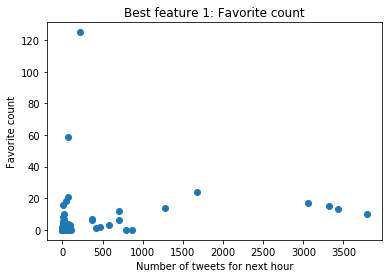

# Authors


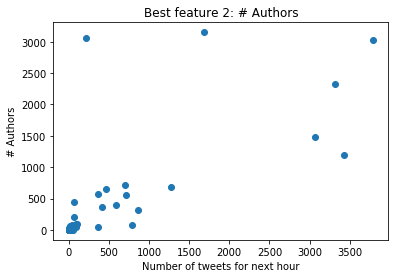

Original followers


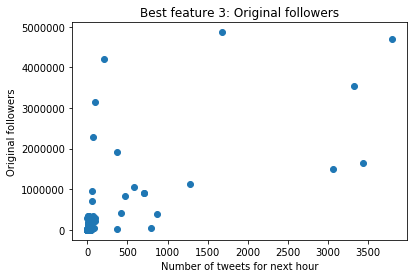

RMSE:  200.999094991
----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------
#nfl
Linear Model - OLS
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     113.6
Date:                Sun, 11 Mar 2018   Prob (F-statistic):          3.64e-147
Time:                        10:38:08   Log-Likelihood:                -4036.3
No. Observations:                 528   AIC:                             8101.
Df Residuals:                     514   BIC:                             8160.
Df Model:           

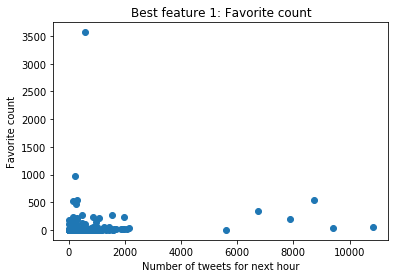

# Tweets


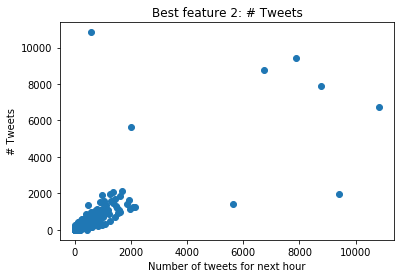

User mentions


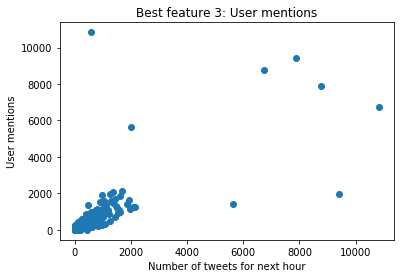

RMSE:  643.844358635
----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------
#sb49
Linear Model - OLS
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     168.8
Date:                Sun, 11 Mar 2018   Prob (F-statistic):          4.35e-181
Time:                        10:38:14   Log-Likelihood:                -5155.6
No. Observations:                 524   AIC:                         1.034e+04
Df Residuals:                     510   BIC:                         1.040e+04
Df Model:          

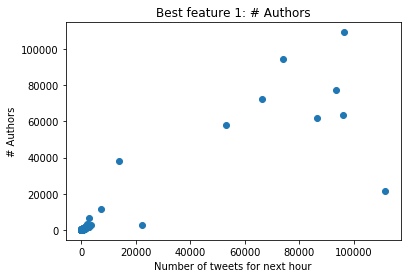

# Tweets


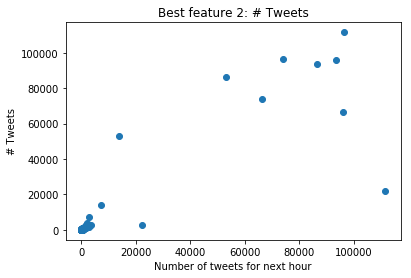

User mentions


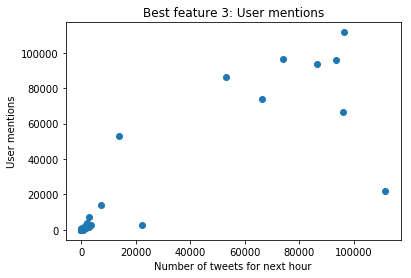

RMSE:  4705.71238417
----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------
#gohawks
Linear Model - OLS
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     53.60
Date:                Sun, 11 Mar 2018   Prob (F-statistic):           1.83e-90
Time:                        10:38:17   Log-Likelihood:                -4295.8
No. Observations:                 521   AIC:                             8620.
Df Residuals:                     507   BIC:                             8679.
Df Model:       

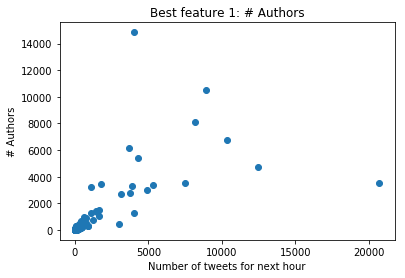

User mentions


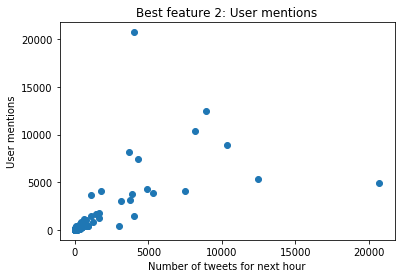

# Tweets


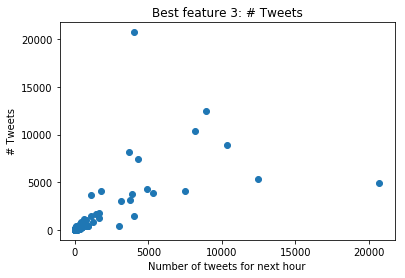

RMSE:  995.532418288
----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------
#patriots
Linear Model - OLS
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     103.7
Date:                Sun, 11 Mar 2018   Prob (F-statistic):          1.47e-139
Time:                        10:38:22   Log-Likelihood:                -4861.1
No. Observations:                 528   AIC:                             9750.
Df Residuals:                     514   BIC:                             9810.
Df Model:      

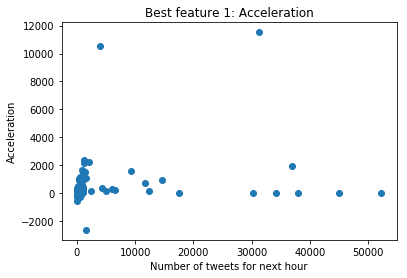

Impressions


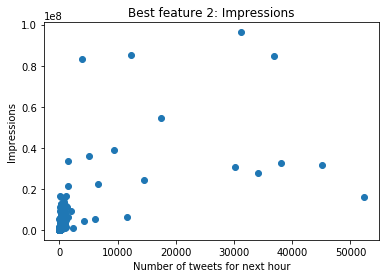

# Authors


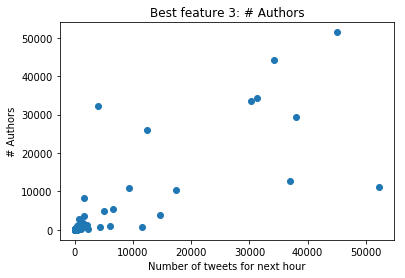

RMSE:  4113.39262346
----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------
#superbowl
Linear Model - OLS
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     214.6
Date:                Sun, 11 Mar 2018   Prob (F-statistic):          8.46e-200
Time:                        10:38:30   Log-Likelihood:                -5251.6
No. Observations:                 509   AIC:                         1.053e+04
Df Residuals:                     495   BIC:                         1.059e+04
Df Model:     

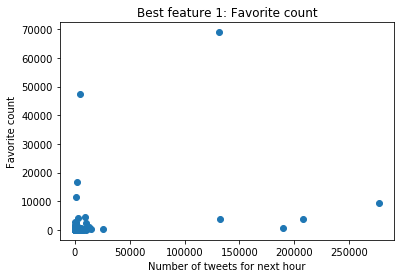

Title length


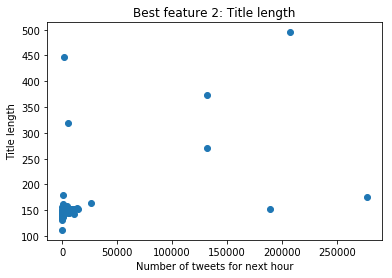

Impressions


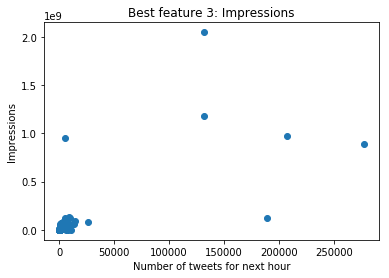

RMSE:  14374.030643
----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------


In [451]:
n_features = 15
#hashtags = ['#gopatriots']
for hashtag in hashtags:
    print(hashtag)
    df = df_map[hashtag].copy()
    X, Y = getXY(df, True)
        
    X = np.nan_to_num(X[:-1])
    Y = Y[1:]
    
    linear_model('summary1.3/', hashtag, X, Y, True)
    print("-"*100)
    print("*"*100)
    print("-"*100)
    #stats_api.add_constant(X)
    #result = stats_api.OLS(Y, X).fit()
    #print(hashtag)
    #print(result.summary())
    #f= open("summary1.2/"+str(n)+'_'+hashtag+".csv","w+")
    #f.write(model.summary().as_csv())
    #f.close()
    #plot_func(X, Y, result)

<h2>Section 1.3 - Non-linear model</h2>

In [406]:
def plot_func_nonlinear(X, Y, best_features):
    #best_features = result.pvalues.argsort()[:3]
    print("Best feature plots")
    i = 1
    for feature in best_features:
        index = feature_names.index(feature)
        print(feature_names[index])
        plt.title("Best feature "+str(i)+": "+str(feature_names[index]))
        plt.xlabel("Number of tweets for next hour")
        plt.ylabel(feature_names[index])
        plt.scatter(Y, X[:, index])
        plt.show()
        i+=1

In [463]:
def nonlinear_model1(hashtag, X, Y, print_=False):
    errors = []
    #print(hashtag)
    print("Non-linear model 1 - Random Forest")
    for train_index, test_index in KFold(n_splits=10).split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        model = RandomForestRegressor(n_estimators=25, max_depth=30, max_features=n_features, bootstrap=True, oob_score=True, random_state=42)
        model.fit(X_train, Y_train)
        preds = model.predict(X_test)

        errors.append(mean_squared_error(Y_test, preds))
    
    best_features = sorted(zip(map(lambda x: round(x, 4), regr.feature_importances_), feature_names), reverse=True)
    #print(model.summary())
    if print_:
        plot_func_nonlinear(X, Y, [best_features[i][1] for i in range(0,3)])
   
    print("RMSE: ", np.sqrt(np.mean(errors)))
    #return errors

In [452]:
def nonlinear_model2(hashtag, X, Y):
    errors = []
    #print(hashtag)
    print("Non-linear model 2 - Neural Network")
    for train_index, test_index in KFold(n_splits=10).split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        scaler = StandardScaler()  
        scaler.fit(X_train)  
        X_train_ss = scaler.transform(X_train)  
        X_test_ss = scaler.transform(X_test)  
        model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=42)
        model.fit(X_train_ss, Y_train)
        preds = model.predict(X_test_ss)

        errors.append(mean_squared_error(Y_test, preds))
    
    print("RMSE: ", np.sqrt(np.mean(errors)))
    #return errors

#gopatriots
Best feature plots
# Authors


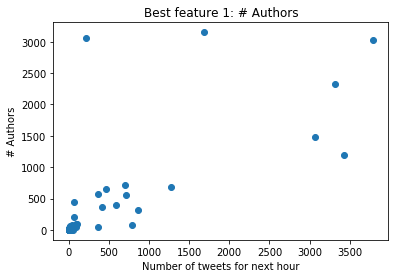

Retweets


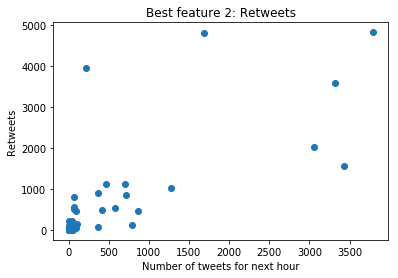

User mentions


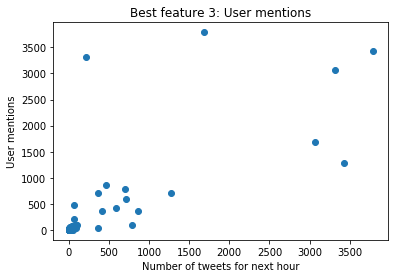

#nfl
Best feature plots
# Authors


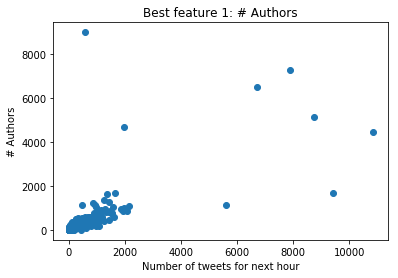

User mentions


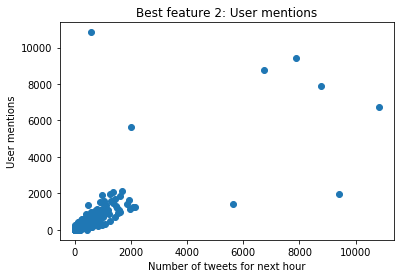

# Tweets


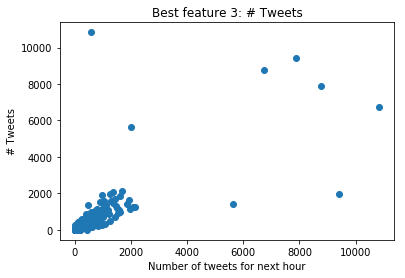

#sb49
Best feature plots
# Authors


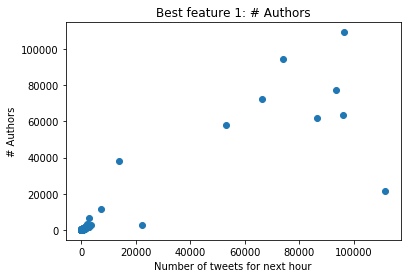

User mentions


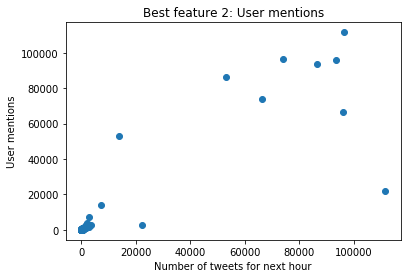

# Tweets


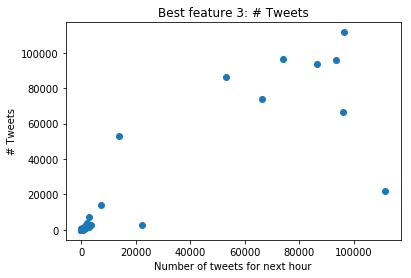

#gohawks
Best feature plots
# Authors


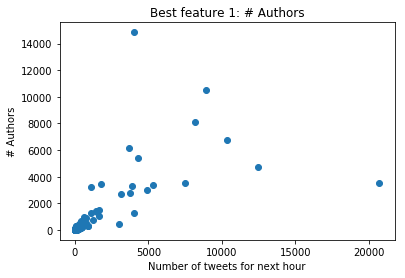

User mentions


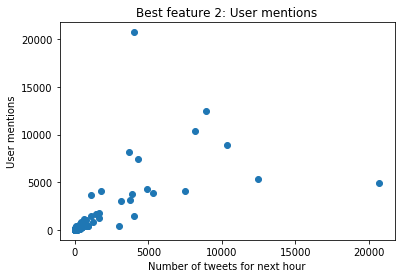

# Tweets


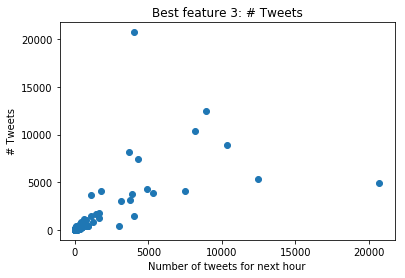

#patriots
Best feature plots
# Authors


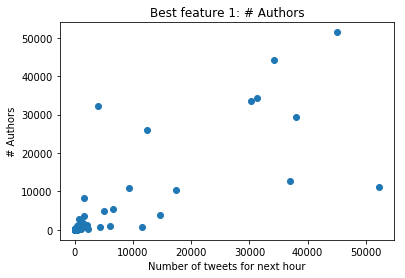

# Tweets


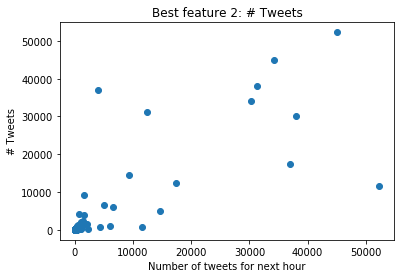

User mentions


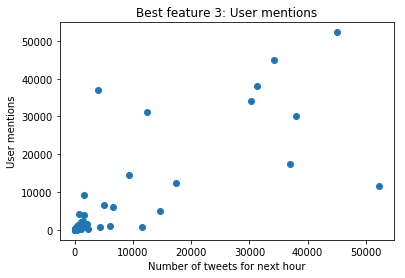

#superbowl
Best feature plots
# Authors


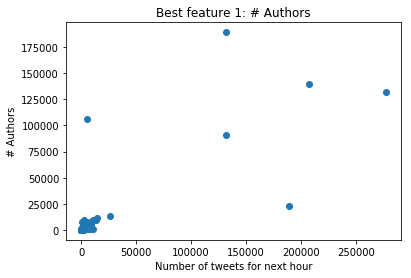

Original followers


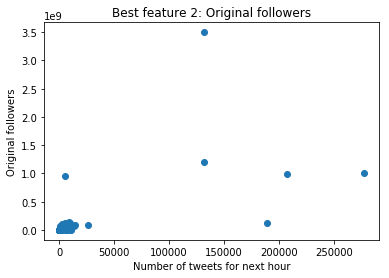

Retweets


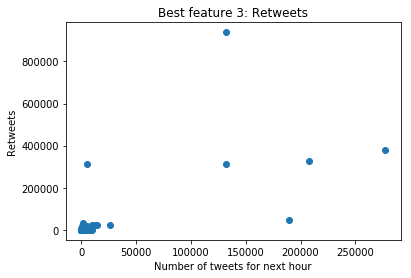

In [412]:
for hashtag in hashtags:
    df = df_map[hashtag].copy()
    X, Y = getXY(df, True)
        
    X = np.nan_to_num(X[:-1])
    Y = Y[1:]
    
    regr = RandomForestRegressor(n_estimators=25, max_depth=30, max_features=n_features, bootstrap=True, oob_score=True, random_state=42)
    regr.fit(X,Y)
    best_features = sorted(zip(map(lambda x: round(x, 4), regr.feature_importances_), feature_names), reverse=True)
    #print([best_features[i][1] for i in range(0,3)])
    print(hashtag)
    plot_func_nonlinear(X, Y, [best_features[i][1] for i in range(0,3)])

In [455]:
import warnings
warnings.filterwarnings("ignore")

<h2>Section 1.4 - 54 models</h2>

In [519]:
def calculate_error(X, Y):
    errors = []
    for train_index, test_index in KFold(n_splits=10).split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        model = stats_api.OLS(Y_train, X_train).fit()
        preds = model.predict(X_test)

        errors.append(mean_squared_error(Y_test, preds))

    return np.sqrt(np.mean(errors))

In [461]:
n_features = 15
#hashtags = ['#gopatriots']
df_a = []
df_d = []
df_b = []
for hashtag in hashtags:
    print(hashtag)
    df = df_map[hashtag].copy()
    df['timestamp'] = df['timestamp'].apply(lambda x:getDate(x))
    
    before = datetime.datetime(2015,2,1,8,0,0)
    after = datetime.datetime(2015,2,1,20,0,0)
     
    df1 = df[df['timestamp'] < before]
    df2 = df[(df['timestamp'] > before) & (df['timestamp'] < after)]
    df3 = df[df['timestamp'] > after]
    
    X1, Y1 = getXY(df1)
    X2, Y2 = getXY(df2)
    X3, Y3 = getXY(df3)
    
    X1 = np.nan_to_num(X1[:-1])
    Y1 = Y1[1:]
    X2 = np.nan_to_num(X2[:-1])
    Y2 = Y2[1:]
    X3 = np.nan_to_num(X3[:-1])
    Y3 = Y3[1:]
    print("Average cross validation errors")
    print("-"*100)
    print("Before superbowl")
    linear_model('summary1.4/linear/before/', hashtag, X1, Y1, False)
    nonlinear_model1(hashtag, X1, Y1)
    nonlinear_model2(hashtag, X1, Y1)
    print("-"*100)
    print("During superbowl")
    linear_model('summary1.4/linear/during/', hashtag, X2, Y2, False)
    nonlinear_model1(hashtag, X2, Y2)
    nonlinear_model2(hashtag, X2, Y2)
    print("-"*100)
    print("After superbowl")
    linear_model('summary1.4/linear/after/', hashtag, X3, Y3, False)
    nonlinear_model1(hashtag, X3, Y3)
    nonlinear_model2(hashtag, X3, Y3)
    
    print("-"*100)
    print("*"*100)
    print("-"*100)
    """
    print("Average cross validation errors")
    print("Before superbowl")
    print(np.sum(calculate_error(X1, Y1))/10.0)
    print("During superbowl")
    print(np.sum(calculate_error(X2, Y2))/10.0)
    print("After superbowl")
    print(np.sum(calculate_error(X3, Y3))/10.0)
    """
    df_a.append(df3)
    df_d.append(df2)
    df_b.append(df1)

#gopatriots
Average cross validation errors
----------------------------------------------------------------------------------------------------
Before superbowl
Linear Model - OLS
RMSE:  52.5310860402
Non-linear model 1 - Random Forest
RMSE:  69.7887413427
Non-linear model 2 - Neural Network
RMSE:  70.3420238344
----------------------------------------------------------------------------------------------------
During superbowl
Linear Model - OLS
RMSE:  823280.112266
Non-linear model 1 - Random Forest
RMSE:  884.756077371
Non-linear model 2 - Neural Network
RMSE:  1650.95455722
----------------------------------------------------------------------------------------------------
After superbowl
Linear Model - OLS
RMSE:  2713.6613878
Non-linear model 1 - Random Forest
RMSE:  10.602501164
Non-linear model 2 - Neural Network
RMSE:  11.4376514982
----------------------------------------------------------------------------------------------------
*********************************************

<h2>Section 1.4 - Q2</h2>

In [381]:
df_before = pd.concat(df_b)
df_during = pd.concat(df_d)
df_after = pd.concat(df_a)

Average cross validation errors
----------------------------------------------------------------------------------------------------
Before superbowl
Linear Model - OLS
RMSE:  2494.95734252
Non-linear model 1 - Random Forest
Best feature plots
# Authors


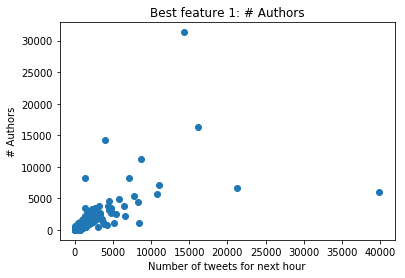

Original followers


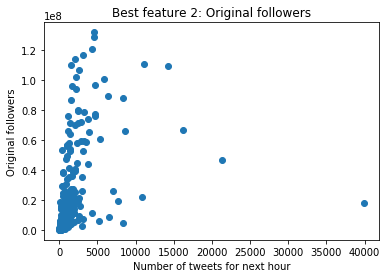

Retweets


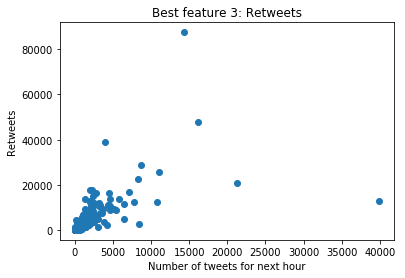

RMSE:  2624.83348255
Non-linear model 2 - Neural Network
RMSE:  2319.52856974
----------------------------------------------------------------------------------------------------
During superbowl
Linear Model - OLS
RMSE:  36345163.3668
Non-linear model 1 - Random Forest
Best feature plots
# Authors


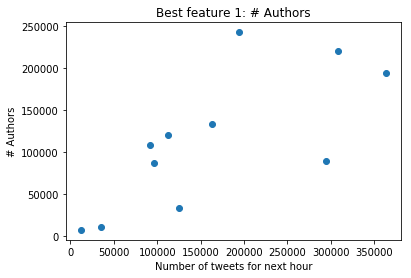

Original followers


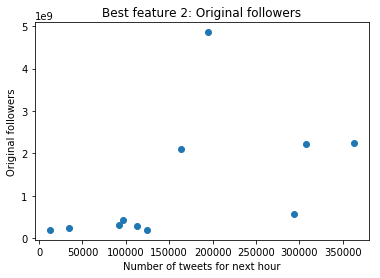

Retweets


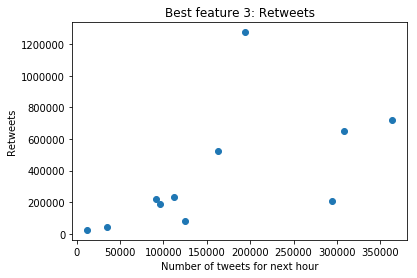

RMSE:  117980.496128
Non-linear model 2 - Neural Network
RMSE:  189411.582479
----------------------------------------------------------------------------------------------------
After superbowl
Linear Model - OLS
RMSE:  364237.623491
Non-linear model 1 - Random Forest
Best feature plots
# Authors


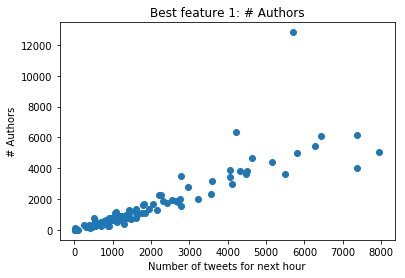

Original followers


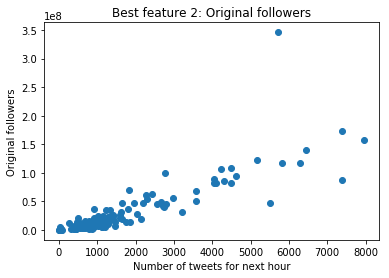

Retweets


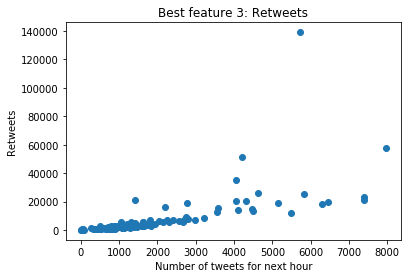

RMSE:  718.999576668
Non-linear model 2 - Neural Network
RMSE:  1857.11172062
----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------


'\nprint("Before superbowl all hashtags")\nstats_api.add_constant(X1)\nresult = stats_api.OLS(Y1, X1).fit()\nprint(result.summary())\nplot_func(X1, Y1, result)\n\nprint("During superbowl all hashtags")\nstats_api.add_constant(X2)\nresult = stats_api.OLS(Y2, X2).fit()\nprint(result.summary())\nplot_func(X2, Y2, result)\n\nprint("After superbowl all hashtags")\nstats_api.add_constant(X3)\nresult = stats_api.OLS(Y3, X3).fit()\nprint(result.summary())\nplot_func(X3, Y3, result)\n\nprint("Average cross validation errors")\nprint("Before superbowl")\nprint(np.sum(calculate_error(X1, Y1))/10.0)\nprint("During superbowl")\nprint(np.sum(calculate_error(X2, Y2))/10.0)\nprint("After superbowl")\nprint(np.sum(calculate_error(X3, Y3))/10.0)\n'

In [464]:
"""
df_all = pd.concat([df_map[hashtag] for hashtag in hashtags])
df_all['timestamp'] = df_all['timestamp'].apply(lambda x:getDate(x))
    
before = datetime.datetime(2015,2,1,8,0,0)
after = datetime.datetime(2015,2,1,20,0,0)
     
df1 = df_all[df_all['timestamp'] < before]
df2 = df_all[(df_all['timestamp'] >= before) & (df_all['timestamp'] < after)]
df3 = df_all[df_all['timestamp'] > after]
 
X1, Y1 = getXY(df1)
X2, Y2 = getXY(df2)
X3, Y3 = getXY(df3)
"""    

X1, Y1 = getXY(df_before)
X2, Y2 = getXY(df_during)
X3, Y3 = getXY(df_after)

X1 = np.nan_to_num(X1[:-1])
Y1 = Y1[1:]
X2 = np.nan_to_num(X2[:-1])
Y2 = Y2[1:]
X3 = np.nan_to_num(X3[:-1])
Y3 = Y3[1:]

print("Average cross validation errors")
print("-"*100)
print("Before superbowl")
linear_model('summary1.4/linear/before/', 'Combined', X1, Y1, False)
nonlinear_model1(hashtag, X1, Y1, True)
nonlinear_model2(hashtag, X1, Y1)
print("-"*100)
print("During superbowl")
linear_model('summary1.4/linear/during/', 'Combined', X2, Y2, False)
nonlinear_model1(hashtag, X2, Y2, True)
nonlinear_model2(hashtag, X2, Y2)
print("-"*100)
print("After superbowl")
linear_model('summary1.4/linear/after/', 'Combined', X3, Y3, False)
nonlinear_model1(hashtag, X3, Y3, True)
nonlinear_model2(hashtag, X3, Y3)

print("-"*100)
print("*"*100)
print("-"*100)
"""
print("Before superbowl all hashtags")
stats_api.add_constant(X1)
result = stats_api.OLS(Y1, X1).fit()
print(result.summary())
plot_func(X1, Y1, result)

print("During superbowl all hashtags")
stats_api.add_constant(X2)
result = stats_api.OLS(Y2, X2).fit()
print(result.summary())
plot_func(X2, Y2, result)

print("After superbowl all hashtags")
stats_api.add_constant(X3)
result = stats_api.OLS(Y3, X3).fit()
print(result.summary())
plot_func(X3, Y3, result)

print("Average cross validation errors")
print("Before superbowl")
print(np.sum(calculate_error(X1, Y1))/10.0)
print("During superbowl")
print(np.sum(calculate_error(X2, Y2))/10.0)
print("After superbowl")
print(np.sum(calculate_error(X3, Y3))/10.0)
"""

In [357]:
print(hashtags)

['#gopatriots', '#nfl', '#sb49', '#gohawks', '#patriots', '#superbowl']


<h2>Section 1.5</h2>

In [470]:
#n : number of hours you want to merge
#f : features in each row
#x : X_map value
#y : Y_map value
def getprev_n_merged(n,f,X,y):
    #print(X.head(1))
    #X = X.as_matrix()
    X_new = []
    rnew = []
    for row in X[:n]:
        rnew = rnew + list(row)
    
    X_new.append(rnew)
    for row in X[n:]:
        rnew = rnew[f:]+list(row)
        X_new.append(rnew)
    print(len(X_new[:-1]),len(list(y[n:])))
    return X_new[:-1],list(y)[n:]

In [478]:
all_data = pd.concat([df_before, df_during, df_after])
print(len(all_data))
X, Y = getXY(all_data)
print(len(X))
X_5, Y_5 = getprev_n_merged(5, 15, X, Y) 

3136263
587
582 582


In [476]:
len(X_5)

582

In [528]:
model = RandomForestRegressor(n_estimators=25, max_depth=30, max_features=n_features, bootstrap=True, oob_score=True, random_state=42)
model.fit(X_5, Y_5)
#preds = model.predict(X_test)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features=15, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=25, n_jobs=1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

In [485]:
best_features = sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), feature_names), reverse=True)

In [503]:
directory = 'test_data/'
for filename in os.listdir(directory):
    print(filename)
    location = directory + filename
    with open(location) as json_data:
        for line in json_data:
            d = json.loads(line)
            pp.pprint(d)
            break
    #data = pd.read_csv(location, sep=" ", header=None)
    #data = pd.read_table(location)
    #print(data.head())
    break

sample2_period2.txt
{ 'author': { 'author_img': 'http://pbs.twimg.com/profile_images/443477546126946304/L5m6oTRp_normal.jpeg',
              'description': 'Authentic cooking in our traditional Mexican '
                             'haciendas, El Torito focuses on using fresh, '
                             'high-quality ingredients to prepare '
                             'made-from-scratch Mexican cuisine.',
              'followers': 498.0,
              'image_url': 'http://pbs.twimg.com/profile_images/443477546126946304/L5m6oTRp_normal.jpeg',
              'name': 'El Torito',
              'nick': 'eltorito',
              'type': 'twitter',
              'url': 'http://twitter.com/eltorito'},
  'citation_date': 1422817200,
  'citation_url': '',
  'firstpost_date': 1422817200,
  'highlight': 'Countdown to kickoff. #SuperBowlXLIX http://t.co/3A9270OLCA',
  'metrics': { 'acceleration': 0,
               'citations': { 'data': [ { 'citations': 0,
                                  

In [517]:
directory = 'test_data/'
bypass=False
for filename in os.listdir(directory):
    print(filename)
    location = directory + filename
    filename = filename.strip(".txt")
    df = pd.DataFrame(columns=df_columns)
    lno = 0
    print("Processing ",filename)
    with open(location, "r") as file_obj:
        if(not os.path.isfile('temp/'+filename+'.csv') or bypass):
            writer=csv.writer(open('temp/'+filename+'.csv','w'))
            writer.writerow(df_columns)
            line = file_obj.readline()
            while(line):
                if(lno%20000 == 0):
                    print(lno)
                j = json.loads(line)
                lno+=1
                #pp.pprint(j)
                #must need columns
                timestamp =j['citation_date']
                followers =j['author']['followers']
                retweets = j['metrics']['citations']['total']
                #useful for later
                author_id = j['author']['url']
                tweet_id = j['tweet']['id']
                # additional features
                firstpost = j['firstpost_date']
                acceleration = j['metrics']['acceleration']
                impressions = j['metrics']['impressions']
                peak = j['metrics']['peak']
                ranking_score = j['metrics']['ranking_score']
                org_followers = j['original_author']['followers']
                #influence = j['original_author']['influence_level']
                title = j['title']
                user_mentions = j['tweet']['entities']['user_mentions']
                favorite_count = j['tweet']['favorite_count']
                sensitivity = j['tweet']['possibly_sensitive']
                retweet_count = j['tweet']['retweet_count']
                location=j['tweet']['user']['location']
                writer.writerow([timestamp, tweet_id, author_id, followers, retweets,
                           firstpost,
                           acceleration, impressions, peak, ranking_score, 
                           org_followers, 
                           title, 
                           user_mentions, 
                           favorite_count, sensitivity, retweet_count, location])
                line = file_obj.readline()
        else:
            print("File Exists!")

sample2_period2.txt
Processing  sample2_period2
File Exists!
sample7_period3.txt
Processing  sample7_period3
File Exists!
sample4_period1.txt
Processing  sample4_period1
File Exists!
sample8_period1.txt
Processing  sample8_period1
File Exists!
sample1_period1.txt
Processing  sample1_period1
File Exists!
sample6_period2.txt
Processing  sample6_period2
File Exists!
sample3_period3.txt
Processing  sample3_period3
File Exists!
sample10_period3.txt
Processing  sample10_period3
File Exists!
sample9_period2.txt
Processing  sample9_period2
File Exists!
sample5_period1.txt
Processing  sample5_period1
0


In [518]:
df_test = {} # to store dfs for each file
for filename in os.listdir(directory):
    filename = filename.strip(".txt")
    if filename=='sample5_period1':
        continue
    print('loaded dataframe',filename)
    df_test[filename] = pd.read_csv('temp/'+filename+'.csv')

loaded dataframe sample2_period2
loaded dataframe sample7_period3
loaded dataframe sample4_period1
loaded dataframe sample8_period1
loaded dataframe sample1_period1
loaded dataframe sample6_period2
loaded dataframe sample3_period3
loaded dataframe sample10_period3
loaded dataframe sample9_period2


In [524]:
df_test['sample2_period2']

,timestamp,tweet_id,author_id,followers,retweets,firstpost,acceleration,impressions,peak,ranking_score,org_followers,title,user_mentions,favorite_count,sensitivity,retweet_count,location
0,1422817200,561962185455587329,http://twitter.com/eltorito,498.0,1,1422817200,0,478,0,4.299383,498.0,NaN,[],0,False,0,NaN
1,1422817200,561962185979879425,http://twitter.com/marandatv,1680.0,1,1422817200,0,1673,0,3.900696,1680.0,NaN,[],0,False,0,Grand Rapids Michigan
2,1422817201,561962188139544576,http://twitter.com/danicakombol,11290.0,1,1422817201,0,11505,0,7.472405,11290.0,NaN,[],0,False,0,Everywhere
3,1422817201,561962191075946497,http://twitter.com/bowlingball,6666.0,1,1422817201,0,6611,0,3.922442,6666.0,NaN,[],0,False,0,Daytona Beach
4,1422817201,561962188080828416,http://twitter.com/tweetjojo731,1170.0,1,1422817201,0,1185,0,3.838048,1170.0,NaN,"[{'indices': [58, 69], 'id': 2298405554, 'id_s...",0,False,0,Chandler AZ / Chicago ✌✌
5,1422817201,561962191075966976,http://twitter.com/kelsaypayton,270.0,1,1422817201,0,265,0,3.565628,270.0,NaN,"[{'indices': [0, 14], 'id': 778873712, 'id_str...",0,False,0,Port Huron➡️Kalamazoo
6,1422817202,561962192116137986,http://twitter.com/blueportdotcom,719.0,1,1422817202,0,714,0,3.692058,719.0,NaN,"[{'indices': [17, 26], 'id': 31126587, 'id_str...",0,False,0,"Boston, MA"
7,1422817202,561962195777757186,http://twitter.com/ecardsforyou,5260.0,6,1422817202,0,5275,0,5.111853,5260.0,NaN,[],0,False,0,NY
8,1422817202,561962194787524608,http://twitter.com/smartbowl,255.0,1,1422817202,0,238,0,4.180818,255.0,NaN,[],0,False,0,NaN
9,1422817202,561962194334515200,http://twitter.com/nickeldenver,185.0,1,1422817202,0,108,0,4.121643,185.0,NaN,"[{'indices': [52, 65], 'id': 2686494368, 'id_s...",0,False,0,"Hotel Teatro, Denver"


In [544]:
for filename in os.listdir(directory):
    print(filename)
    filename = filename.strip(".txt")
    if filename=='sample5_period1' or filename=='sample8_period1':
        continue
    df = df_test[filename].copy()
    #print(df.head())
    df = df.fillna("")
    X_test, Y_test = getXY(df, True)
    X_test = np.nan_to_num(X_test)
    print(len(X_test))
    X_5_test, Y_5_test = getprev_n_merged(5, 15, X_test, Y_test) 
    print(len(X_5_test), len(X_5_test[0]))
    preds = model.predict(X_5_test)
    print("RMSE: ", np.sqrt(mean_squared_error(Y_5_test, preds)))

sample2_period2.txt
24
19 19
19 75
RMSE:  40634.0646909
sample7_period3.txt
6
1 1
1 75
RMSE:  19.88
sample4_period1.txt
6
1 1
1 75
RMSE:  65.4
sample8_period1.txt
sample1_period1.txt
80
75 75
75 75
RMSE:  139.132128894
sample6_period2.txt
26
21 21
21 75
RMSE:  12579.7884053
sample3_period3.txt
6
1 1
1 75
RMSE:  395.72
sample10_period3.txt
6
1 1
1 75
RMSE:  53.04
sample9_period2.txt
20
15 15
15 75
RMSE:  739.43280598
sample5_period1.txt
